In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt

In [5]:
stock = yf.Ticker("TATAMOTORS.NS")
df = stock.history(period="max")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1995-12-25,53.472782,53.472782,53.472782,53.472782,0,0.0,0.0
1995-12-26,53.472782,53.472782,53.472782,53.472782,0,0.0,0.0
1995-12-27,53.472782,53.472782,53.472782,53.472782,0,0.0,0.0
1995-12-28,53.472782,53.472782,53.472782,53.472782,0,0.0,0.0
1995-12-29,53.472782,53.472782,53.472782,53.472782,0,0.0,0.0


In [6]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-06,444.450012,447.000000,439.549988,442.000000,6795084,0.0,0.0
2023-02-07,441.700012,443.399994,432.899994,435.450012,9023645,0.0,0.0
2023-02-08,435.450012,441.000000,431.549988,440.100006,8668267,0.0,0.0
2023-02-09,440.000000,440.700012,433.549988,436.750000,7349418,0.0,0.0
2023-02-10,437.950012,447.799988,431.200012,445.850006,14798390,0.0,0.0


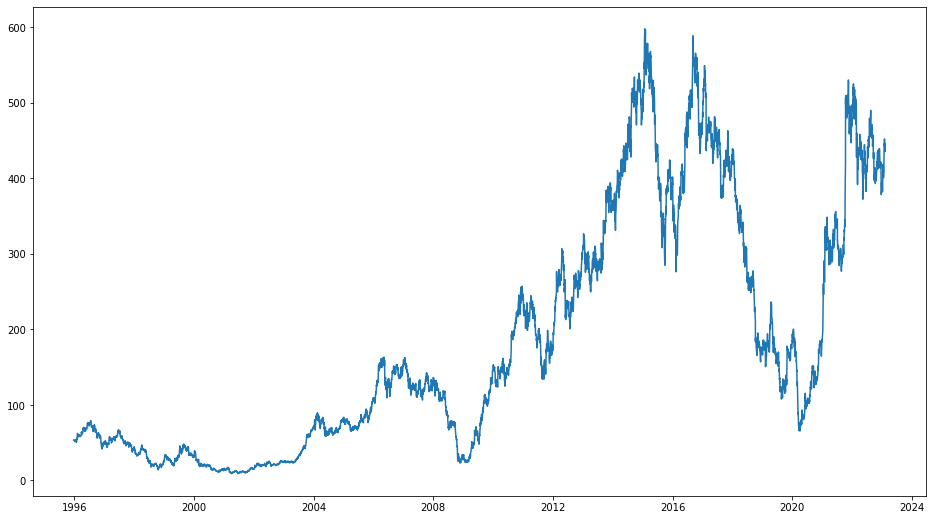

In [8]:
plt.figure(figsize = (16, 9))
plt.plot(df["Close"])

In [11]:
#Saving the historical data for tata motors
df.to_csv("../data/TATAMOTORS.csv")